In [3]:
%pip install ultralytics
import ultralytics
import numpy as np
import matplotlib.pyplot as plt
ultralytics.checks()

Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/112.6 GB disk)


In [119]:
from ultralytics import YOLO

# Load a pretrained YOLO11n model
model = YOLO("yolo11x-obb.pt")

# Run inference on an image
results = model("tank2.png")  # results list


image 1/1 /content/tank2.png: 1024x1024 145.9ms
Speed: 5.1ms preprocess, 145.9ms inference, 3.9ms postprocess per image at shape (1, 3, 1024, 1024)


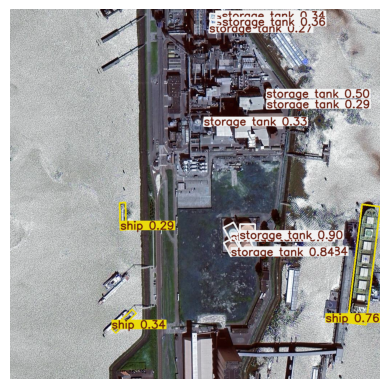

In [120]:
# Display the image using matplotlib
plt.imshow(results[0].plot())
plt.axis("off")  # Turn off axes for better visualization
plt.show()

In [121]:
import numpy as np
predictions = results[0].obb.cls

In [122]:
labels = results[0].names
predictions = predictions.detach().cpu().numpy()

In [123]:
# value counts
unique, counts = np.unique(predictions, return_counts=True)
dict(zip([labels[i] for i in unique], counts))

{'ship': 3, 'storage tank': 12}

In [124]:
xywhrs = results[0].obb.xywhr.detach().cpu().numpy()
tanks_pos = xywhrs[predictions == 2]

In [125]:
diameters = np.mean(tanks_pos[:, 2:4], axis=1)
uncertainty = np.std(tanks_pos[:, 2:4], axis=1)

In [126]:
diameters

array([     42.427,      36.951,      36.584,      37.417,      23.537,      15.797,      15.747,      19.998,       15.49,      15.332,      23.135,      16.996], dtype=float32)

In [127]:
uncertainty

array([   0.070255,      5.0455,      5.1321,      5.9591,     0.25237,     0.29193,     0.31877,    0.047368,    0.062407,     0.10308,     0.11719,     0.36986], dtype=float32)